# Applying SHRED to the Mice Dataset 

Dataset obtained from Allen Barain Atlas https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

Goal: Reconstruct LFP potential of different brain regions from only one session 756029989 and flash stimuli

LFP band: 
- ~2.5 kHz original sample rate
- 1000 Hz analog lo-pass
- 625 Hz digital lo-pass
- NWB includes every 2nd sample and every 4th channel

In [1]:
# Importing all dependencies 
import numpy as np
import numpy as np
import torch
import subprocess
import os
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import mne
from scipy.signal import butter, filtfilt
from scipy.signal import welch
from scipy.interpolate import CubicSpline
from scipy.io import loadmat
from sklearn.linear_model import Ridge

In [2]:
import xarray as xr
import pandas as pd
from scipy.ndimage import gaussian_filter
from pathlib import Path
import json
from IPython.display import display
from PIL import Image

from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

In [3]:
#Set up data cache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

data_directory = "/home/amy/SHRED_neuro/mice/data" #where data will be stored
manifest_path = os.path.join(data_directory, 'manifest.json')
cache = EcephysProjectCache.from_warehouse(manifest = manifest_path)

/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sessions = cache.get_session_table()

print('Total number of sessions: ' + str(len(sessions)))

sessions.head()


# Can also filter which mice to select
filtered_sessions = sessions[(sessions.index == 756029989)]

filtered_sessions.head()

Total number of sessions: 58


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
756029989,2019-10-03T00:00:00Z,734865738,brain_observatory_1.1,96.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,684,2214,6,"[TH, DG, CA3, CA1, VISl, nan, PO, Eth, LP, VIS..."


In [5]:
#Loading dataset for specific session
session_id = 756029989 # for example
session = cache.get_session_data(session_id)

print([attr_or_method for attr_or_method in dir(session) if attr_or_method[0] != '_'])


/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


['DETAILED_STIMULUS_PARAMETERS', 'LazyProperty', 'age_in_days', 'api', 'channel_structure_intervals', 'channels', 'conditionwise_spike_statistics', 'ecephys_session_id', 'from_nwb_path', 'full_genotype', 'get_current_source_density', 'get_inter_presentation_intervals_for_stimulus', 'get_invalid_times', 'get_lfp', 'get_parameter_values_for_stimulus', 'get_pupil_data', 'get_screen_gaze_data', 'get_stimulus_epochs', 'get_stimulus_parameter_values', 'get_stimulus_table', 'inter_presentation_intervals', 'invalid_times', 'mean_waveforms', 'metadata', 'num_channels', 'num_probes', 'num_stimulus_presentations', 'num_units', 'optogenetic_stimulation_epochs', 'presentationwise_spike_counts', 'presentationwise_spike_times', 'probes', 'rig_equipment_name', 'rig_geometry_data', 'running_speed', 'session_start_time', 'session_type', 'sex', 'specimen_name', 'spike_amplitudes', 'spike_times', 'stimulus_conditions', 'stimulus_names', 'stimulus_presentations', 'structure_acronyms', 'structurewise_unit_c

**Importing local field potential (LFP) data**

In [6]:
# list the probes recorded from in this session
session.probes.head()

,description,location,sampling_rate,lfp_sampling_rate,has_lfp_data
id,,,,,
760640083,probeA,See electrode locations,29999.949611,1249.997900,True
760640087,probeB,See electrode locations,29999.902541,1249.995939,True
760640090,probeC,See electrode locations,29999.905275,1249.996053,True
760640094,probeD,See electrode locations,29999.905275,1249.996053,True
760640097,probeE,See electrode locations,29999.985335,1249.999389,True


In [7]:
{session.probes.loc[probe_id].description : 
     list(session.channels[session.channels.probe_id == probe_id].ecephys_structure_acronym.unique())
     for probe_id in session.probes.index.values}

/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


{'probeA': [nan, 'APN', 'DG', 'CA1', 'VISam'],
 'probeB': ['VISpm', nan, 'LP', 'DG', 'CA1', 'PO', 'Eth'],
 'probeC': ['VISp', nan, 'POL', 'APN', 'MB', 'SCig', 'POST', 'SUB'],
 'probeD': ['VISl', nan, 'TH', 'DG', 'CA3', 'CA1'],
 'probeE': [nan, 'VPM', 'TH', 'LGd', 'CA3', 'CA2', 'CA1', 'VISal'],
 'probeF': [nan, 'DG', 'CA1', 'VISrl']}

In [ ]:
probe_id = session.probes.index.values[0] ## Select 0 for probe A and 2 for probe C
lfp = session.get_lfp(probe_id)

/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 beca

In [ ]:
## For probe C, mismatch between channels in lfp["channel"] and session.channels.index
lfp_channels = lfp["channel"].values.tolist()
valid_channels = [ch for ch in lfp_channels if ch in session.channels.index]
structure_acronyms, intervals = session.channel_structure_intervals(valid_channels)
interval_midpoints = [aa + (bb - aa) / 2 for aa, bb in zip(intervals[:-1], intervals[1:])]

print(structure_acronyms)
print(intervals)
print(interval_midpoints)

['APN' 'DG' 'CA1' 'VISam' nan]
[ 0 27 35 51 74 87]
[13.5, 31.0, 43.0, 62.5, 80.5]


Aligning the LFP data to a particular stimulus

In [10]:
stim_table = session.get_stimulus_table('flashes')
stim_table.head(10)
stim_table[stim_table['stimulus_condition_id'] == 245].head()

/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


,stimulus_block,start_time,stop_time,phase,stimulus_name,contrast,color,size,orientation,spatial_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3649,1.0,1289.486728,1289.736936,"[0.0, 0.0]",flashes,0.8,1.0,"[300.0, 300.0]",0.0,"[0.0, 0.0]",0.250208,245
3651,1.0,1293.490088,1293.740296,"[0.0, 0.0]",flashes,0.8,1.0,"[300.0, 300.0]",0.0,"[0.0, 0.0]",0.250208,245
3652,1.0,1295.491718,1295.741934,"[0.0, 0.0]",flashes,0.8,1.0,"[300.0, 300.0]",0.0,"[0.0, 0.0]",0.250216,245
3654,1.0,1299.495108,1299.745314,"[0.0, 0.0]",flashes,0.8,1.0,"[300.0, 300.0]",0.0,"[0.0, 0.0]",0.250206,245
3656,1.0,1303.498478,1303.748681,"[0.0, 0.0]",flashes,0.8,1.0,"[300.0, 300.0]",0.0,"[0.0, 0.0]",0.250203,245


In [11]:
# presentation_table = session.stimulus_presentations[session.stimulus_presentations.stimulus_name == 'drifting_gratings']
presentation_table = session.stimulus_presentations[session.stimulus_presentations.stimulus_condition_id == 245]

presentation_times = presentation_table.start_time.values
presentation_ids = presentation_table.index.values

In [12]:
print(presentation_table)

                         stimulus_block   start_time    stop_time       phase  \
stimulus_presentation_id                                                        
3649                                1.0  1289.486728  1289.736936  [0.0, 0.0]   
3651                                1.0  1293.490088  1293.740296  [0.0, 0.0]   
3652                                1.0  1295.491718  1295.741934  [0.0, 0.0]   
3654                                1.0  1299.495108  1299.745314  [0.0, 0.0]   
3656                                1.0  1303.498478  1303.748681  [0.0, 0.0]   
...                                 ...          ...          ...         ...   
3786                                1.0  1563.716018  1563.966216  [0.0, 0.0]   
3788                                1.0  1567.719368  1567.969564  [0.0, 0.0]   
3793                                1.0  1577.727728  1577.977929  [0.0, 0.0]   
3795                                1.0  1581.731038  1581.981251  [0.0, 0.0]   
3796                        

In [13]:
tot_t = 0.25
dt = 1/500
sr = 1/dt
trial_window = np.arange(0, tot_t, dt)
time_selection = np.concatenate([trial_window + t for t in presentation_times])

inds = pd.MultiIndex.from_product((presentation_ids, trial_window), 
                                  names=('presentation_id', 'time_from_presentation_onset'))

ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
ds = ds.assign(time=inds).unstack('time')

aligned_lfp = ds['aligned_lfp']

In [76]:
print(time_selection[:125])

[1289.48672799 1289.48872799 1289.49072799 1289.49272799 1289.49472799
 1289.49672799 1289.49872799 1289.50072799 1289.50272799 1289.50472799
 1289.50672799 1289.50872799 1289.51072799 1289.51272799 1289.51472799
 1289.51672799 1289.51872799 1289.52072799 1289.52272799 1289.52472799
 1289.52672799 1289.52872799 1289.53072799 1289.53272799 1289.53472799
 1289.53672799 1289.53872799 1289.54072799 1289.54272799 1289.54472799
 1289.54672799 1289.54872799 1289.55072799 1289.55272799 1289.55472799
 1289.55672799 1289.55872799 1289.56072799 1289.56272799 1289.56472799
 1289.56672799 1289.56872799 1289.57072799 1289.57272799 1289.57472799
 1289.57672799 1289.57872799 1289.58072799 1289.58272799 1289.58472799
 1289.58672799 1289.58872799 1289.59072799 1289.59272799 1289.59472799
 1289.59672799 1289.59872799 1289.60072799 1289.60272799 1289.60472799
 1289.60672799 1289.60872799 1289.61072799 1289.61272799 1289.61472799
 1289.61672799 1289.61872799 1289.62072799 1289.62272799 1289.62472799
 1289.

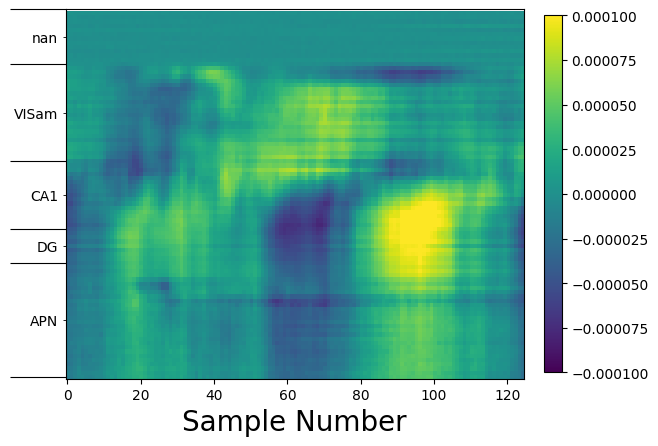

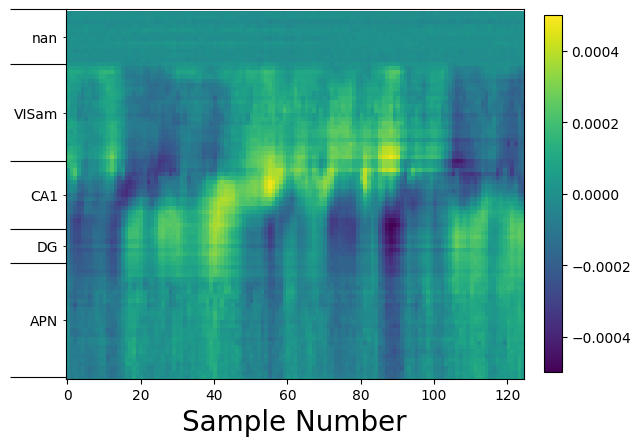

In [14]:
fig, ax = plt.subplots()
im = ax.imshow(aligned_lfp.mean(dim='presentation_id'), aspect='auto', origin='lower', vmin=-1e-4, vmax=1e-4)

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints, minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
plt.tick_params("y", which="major", labelleft=False, length=40)

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(trial_window), num_time_labels)).astype(int) - 1
# time_labels = [ f"{val:1.3}" for val in lfp["time"].values[window][time_label_indices]]
# ax.set_xticks(time_label_indices + 0.5)
# ax.set_xticklabels(time_labels)
ax.set_xlabel("Sample Number", fontsize=20)
plt.colorbar(im, fraction=0.036, pad=0.04)

plt.show()


## just one
fig, ax = plt.subplots()
im = ax.imshow(aligned_lfp[:,2,:], aspect='auto', origin='lower', vmin=-0.5e-3, vmax=0.5e-3)

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints, minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
plt.tick_params("y", which="major", labelleft=False, length=40)

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(trial_window), num_time_labels)).astype(int) - 1
# time_labels = [ f"{val:1.3}" for val in lfp["time"].values[window][time_label_indices]]
# ax.set_xticks(time_label_indices + 0.5)
# ax.set_xticklabels(time_labels)
ax.set_xlabel("Sample Number", fontsize=20)
plt.colorbar(im, fraction=0.036, pad=0.04)

plt.show()



(76, 375)


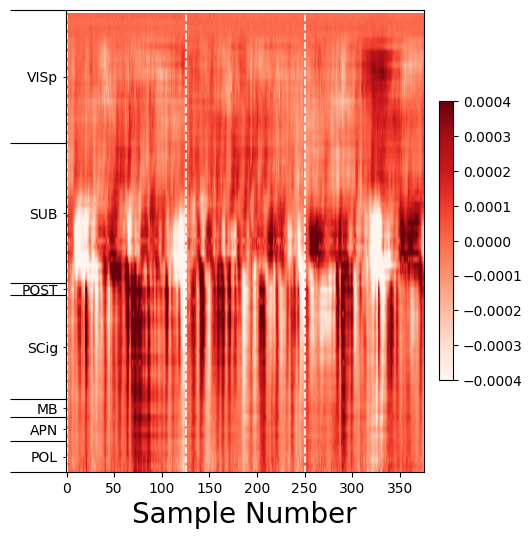

In [68]:
### save data as np arrays
sens_max = 76
probe = 'c'

lfp_np = aligned_lfp.data
data = np.hstack((lfp_np[:sens_max,0,:], lfp_np[:sens_max,1,:], lfp_np[:sens_max,3,:]))
print(data.shape)

n_t = data.shape[1]
n_s = data.shape[0]


## Plot the numpy array
fig, ax = plt.subplots(figsize = (5,6))
im = ax.imshow(data, aspect='auto', origin='lower', vmin=-0.4e-3, vmax=0.4e-3, cmap = 'Reds')

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints,  minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
plt.tick_params("y", which="major", labelleft=False, length=40)
for y in [0,tot_t*sr, tot_t * 2* sr]:
    plt.axvline(y, color='white', linestyle='--', linewidth = '1.25')
ax.set_xlim((-1,data.shape[1]))
ax.set_ylim((0,sens_max))

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(trial_window), num_time_labels)).astype(int) - 1

ax.set_xlabel("Sample Number", fontsize=20)
plt.colorbar(im, fraction=0.036, pad=0.04)
plt.show()



**Applying SHRED on Dataset**

In [ ]:
#Importing packages

os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.chdir("../") 

# Change into the directory
os.chdir("/home/amy/SHRED_neuro/sindy-shred") ## Change to where the repo was cloned

from processdata import load_data
from processdata import TimeSeriesDataset
import sindy
import pysindy as ps
from pysindy.differentiation import FiniteDifference

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [70]:
load_X = data.T

latent_dim = 64
poly_order = 1
include_sine = False
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)
os.chdir("/home/amy/SHRED_neuro/sindy-shred")
import sindy_shred
num_neurons = 3 
lags = 30
test_val_size = int(tot_t*sr - lags)
print(n_t)
train_indices = np.arange(0, int(n_t - lags - test_val_size))
mask = np.ones(n_t - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n_t - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[int(test_val_size/2):test_val_size]
test_indices = valid_test_indices[:int(test_val_size/2)]


375


In [ ]:
# Randomly select the sensors from the CA1 region
print(intervals)
print(structure_acronyms)

for k in range(2):
    indices = np.random.choice(41-31, size= num_neurons, replace=False) 
    neuron_locations = indices+31
    file_path = f"/home/amy/SHRED_neuro/mice/data_output/exp_Bi/flash/neuron_loc_{probe}_{k}.npy"
    print(file_path)
    np.save(file_path, neuron_locations)
    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n_t - lags, lags, num_neurons))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, neuron_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = sindy_shred.SINDy_SHRED(num_neurons, n_s, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1,
                                    library_dim=library_dim, poly_order=poly_order,
                                    include_sine=include_sine, dt=dt, layer_norm=False).to(device)

    validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=200,
                                        lr=1e-3, verbose=True, threshold=0.25, patience=5, sindy_regularization=10.0,
                                        optimizer="AdamW", thres_epoch=100)

    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    mse_test = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    print('mse test', mse_test)
    train_recons = sc.inverse_transform(shred(train_dataset.X).detach().cpu().numpy())
    train_ground_truth = sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())
    mse_train = np.linalg.norm(train_recons - train_ground_truth) / np.linalg.norm(train_ground_truth)
    print('mse train', mse_train)


    file_path = f"/home/amy/SHRED_neuro/mice/data_output/exp_Bi/flash/train_recons_{probe}_{k}.npy"
    np.save(file_path, train_recons)
    file_path = f"/home/amy/SHRED_neuro/mice/data_output/exp_Bi/flash/test_recons_{probe}_{k}.npy"
    np.save(file_path, test_recons)
    file_path = f"/home/amy/SHRED_neuro/mice/data_output/exp_Bi/flash/train_gt_{probe}_{k}.npy"
    np.save(file_path, train_ground_truth)
    file_path = f"/home/amy/SHRED_neuro/mice/data_output/exp_Bi/flash/test_gt_{probe}_{k}.npy"
    np.save(file_path, test_ground_truth)
    file_path = f"/home/amy/SHRED_neuro/mice/data_output/exp_Bi/flash/mse_{probe}_{k}.npy"
    np.save(file_path, [mse_train, mse_test])

[ 0  5  9 12 29 31 54 76 81]
['POL' 'APN' 'MB' 'SCig' 'POST' 'SUB' 'VISp' nan]
/home/amy/SHRED_neuro/mice/data_output/exp_1/flash/neuron_loc_c_0.npy
1 : tensor(0.2492, device='cuda:0', grad_fn=<AddBackward0>)
2 : tensor(0.2044, device='cuda:0', grad_fn=<AddBackward0>)
3 : tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)
4 : tensor(0.0611, device='cuda:0', grad_fn=<AddBackward0>)
5 : tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)
6 : tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)
7 : tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)
8 : tensor(0.0375, device='cuda:0', grad_fn=<AddBackward0>)
9 : tensor(0.0429, device='cuda:0', grad_fn=<AddBackward0>)
10 : tensor(0.0425, device='cuda:0', grad_fn=<AddBackward0>)


11 : tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)
12 : tensor(0.0368, device='cuda:0', grad_fn=<AddBackward0>)
13 : tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
14 : tensor(0.0403, device='cuda:0', grad_fn=<AddBackward0>)
15 : tensor(0.0369, device='cuda:0', grad_fn=<AddBackward0>)
16 : tensor(0.0351, device='cuda:0', grad_fn=<AddBackward0>)
17 : tensor(0.0357, device='cuda:0', grad_fn=<AddBackward0>)
18 : tensor(0.0357, device='cuda:0', grad_fn=<AddBackward0>)
19 : tensor(0.0359, device='cuda:0', grad_fn=<AddBackward0>)
20 : tensor(0.0356, device='cuda:0', grad_fn=<AddBackward0>)
21 : tensor(0.0367, device='cuda:0', grad_fn=<AddBackward0>)
22 : tensor(0.0367, device='cuda:0', grad_fn=<AddBackward0>)
23 : tensor(0.0354, device='cuda:0', grad_fn=<AddBackward0>)
24 : tensor(0.0348, device='cuda:0', grad_fn=<AddBackward0>)
25 : tensor(0.0342, device='cuda:0', grad_fn=<AddBackward0>)
26 : tensor(0.0340, device='cuda:0', grad_fn=<AddBackward0>)
27 : tensor(0.0339, devi

Plotting the Data

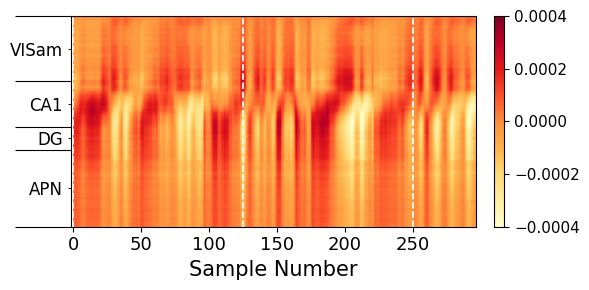

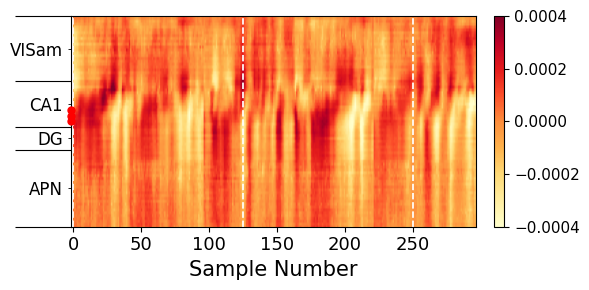

In [ ]:
## Probe A
structure_acronyms = ['APN', 'DG', 'CA1', 'VISam', 'nan']
intervals = [0, 27, 35, 51, 74 ,87]
interval_midpoints = [13.5, 31.0, 43.0, 62.5, 80.5]

### Load the data 
sens_max = 74
probe = 'a'

data_train = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_Bi/flash/train_recons_a_1.npy")
data_test = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_Bi/flash/test_recons_a_1.npy")
data_recon = np.vstack((data_train, data_test))

data_train = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_Bi/flash/train_gt_a_1.npy")
data_test = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_Bi/flash/test_gt_a_1.npy")
data_gt= np.vstack((data_train, data_test))
neuron_loc = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_Bi/flash/neuron_loc_a_1.npy")

## Plot the Reconstruction
fig, ax = plt.subplots(figsize = (6,3))
im = ax.imshow(data_recon.T, aspect='auto', origin='lower', vmin=-0.4e-3, vmax=0.4e-3, cmap = 'YlOrRd')

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints,  minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.label1.set_fontsize(12) 
    
plt.tick_params("y", which="major", labelleft=False, length=40)
for y in [0,125, 250]:
    plt.axvline(y, color='white', linestyle='--', linewidth = '1.25')

ax.set_xlim((-2,data_recon.shape[0]))
ax.set_ylim((0,sens_max))
plt.tick_params(axis='both', which='major', labelsize=13)

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(trial_window), num_time_labels)).astype(int) - 1

ax.set_xlabel("Sample Number", fontsize=15)
cbar = plt.colorbar(im, fraction=0.036, pad=0.04)
cbar.ax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/mice/data_output/figs/lfp_flash_a_recon.png", transparent = True, dpi = 400)
plt.show()

## Plot the Ground Truth
fig, ax = plt.subplots(figsize = (6,3))
im = ax.imshow(data_gt.T, aspect='auto', origin='lower', vmin=-0.4e-3, vmax=0.4e-3, cmap = 'YlOrRd')

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints,  minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.label1.set_fontsize(12) 
    
plt.tick_params("y", which="major", labelleft=False, length=40)
for y in [0,125, 250]:
    plt.axvline(y, color='white', linestyle='--', linewidth = '1.25')
for k in range(len(neuron_loc)):
    ax.plot(-2, neuron_loc[k], 'o', color='red', zorder = 10,  clip_on=False, markersize = 5) 
ax.set_clip_on(False)
ax.set_xlim((-2,data_gt.shape[0]))
ax.set_ylim((0,sens_max))
plt.tick_params(axis='both', which='major', labelsize=13)

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(trial_window), num_time_labels)).astype(int) - 1

ax.set_xlabel("Sample Number", fontsize=15)
cbar = plt.colorbar(im, fraction=0.036, pad=0.04)
cbar.ax.tick_params(labelsize=11)
plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/mice/data_output/figs/lfp_flash_a_gt.png", transparent = True, dpi = 400)

plt.show()





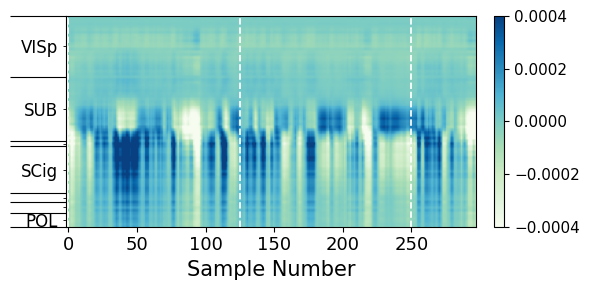

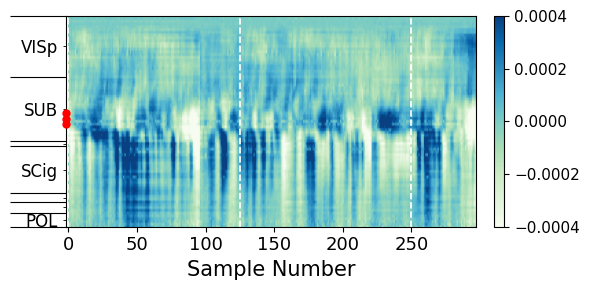

In [ ]:
## Probe C
structure_acronyms = ['POL', '', '', 'SCig', '', 'SUB', 'VISp', 'nan']
intervals = [ 0,  5 , 9 ,12 ,29, 31 ,54, 76 ,81]
interval_midpoints = [2.5, 7.0, 10.5, 20.5, 30.0, 42.5, 65.0, 78.5]

### Load the data 
sens_max = 76
probe = 'c'

data_train = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_Bi/flash/train_recons_c_1.npy")
data_test = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_Bi/flash/test_recons_c_1.npy")
data_recon = np.vstack((data_train, data_test))

data_train = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_Bi/flash/train_gt_c_1.npy")
data_test = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_Bi/flash/test_gt_c_1.npy")
data_gt= np.vstack((data_train, data_test))

## Plot the Reconstruction
fig, ax = plt.subplots(figsize = (6,3))
im = ax.imshow(data_recon.T, aspect='auto', origin='lower', vmin=-0.4e-3, vmax=0.4e-3, cmap = 'GnBu')

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints,  minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.label1.set_fontsize(12) 
    
plt.tick_params("y", which="major", labelleft=False, length=40)
for y in [0,125, 250]:
    plt.axvline(y, color='white', linestyle='--', linewidth = '1.25')

ax.set_xlim((-2,data_recon.shape[0]))
ax.set_ylim((0,sens_max))
plt.tick_params(axis='both', which='major', labelsize=13)

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(trial_window), num_time_labels)).astype(int) - 1

ax.set_xlabel("Sample Number", fontsize=15)
cbar = plt.colorbar(im, fraction=0.036, pad=0.04)
cbar.ax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/mice/data_output/figs/lfp_flash_c_recon.png", transparent = True, dpi = 400)
plt.show()

## Plot the Ground Truth
fig, ax = plt.subplots(figsize = (6,3))
im = ax.imshow(data_gt.T, aspect='auto', origin='lower', vmin=-0.4e-3, vmax=0.4e-3, cmap = 'GnBu')

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints,  minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.label1.set_fontsize(12) 
    
plt.tick_params("y", which="major", labelleft=False, length=40)
for y in [0,125, 250]:
    plt.axvline(y, color='white', linestyle='--', linewidth = '1.25')
for k in range(len(neuron_loc)):
    ax.plot(-2, neuron_loc[k], 'o', color='red', zorder = 10,  clip_on=False, markersize = 5) 
ax.set_clip_on(False)
ax.set_xlim((-2,data_gt.shape[0]))
ax.set_ylim((0,sens_max))
plt.tick_params(axis='both', which='major', labelsize=13)

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(trial_window), num_time_labels)).astype(int) - 1

ax.set_xlabel("Sample Number", fontsize=15)
cbar = plt.colorbar(im, fraction=0.036, pad=0.04)
cbar.ax.tick_params(labelsize=11)
plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/mice/data_output/figs/lfp_flash_c_gt.png", transparent = True, dpi = 400)

plt.show()